In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the datasets
call_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/calls.csv')  # call_id, agent_id, call_duration, wait_time, call_reason_id
customer_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/customers.csv')  # call_id, customer_id, sentiment_score
reason_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/reason.csv')  # call_reason_id, call_reason_description
sentiment_data = pd.read_csv('/content/drive/MyDrive/assignments/Skyhack/sentiment_statistics.csv')  # call_id, sentiment

# Printing the columns of each dataframe to check if 'call_id' exists
print("Call data columns:", call_data.columns)
print("Customer data columns:", customer_data.columns)
print("Reason data columns:", reason_data.columns)
print("Sentiment data columns:", sentiment_data.columns)

Call data columns: Index(['call_id', 'customer_id', 'agent_id', 'call_start_datetime',
       'agent_assigned_datetime', 'call_end_datetime', 'call_transcript'],
      dtype='object')
Customer data columns: Index(['customer_id', 'customer_name', 'elite_level_code'], dtype='object')
Reason data columns: Index(['call_id', 'primary_call_reason'], dtype='object')
Sentiment data columns: Index(['call_id', 'agent_id', 'agent_tone', 'customer_tone',
       'average_sentiment', 'silence_percent_average'],
      dtype='object')


In [3]:
# Merging datasets
merged_data = pd.merge(call_data, customer_data, on='customer_id')
merged_data = pd.merge(merged_data, reason_data, on='call_id')
merged_data = pd.merge(merged_data, sentiment_data, on='call_id')

In [4]:
merged_data.head()

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_id_y,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,963118,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,519057,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,158319,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,488324,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,721730,neutral,polite,-0.05,0.35


In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66653 entries, 0 to 66652
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call_id                  66653 non-null  int64  
 1   customer_id              66653 non-null  int64  
 2   agent_id_x               66653 non-null  int64  
 3   call_start_datetime      66653 non-null  object 
 4   agent_assigned_datetime  66653 non-null  object 
 5   call_end_datetime        66653 non-null  object 
 6   call_transcript          66653 non-null  object 
 7   customer_name            66653 non-null  object 
 8   elite_level_code         42694 non-null  float64
 9   primary_call_reason      66653 non-null  object 
 10  agent_id_y               66653 non-null  int64  
 11  agent_tone               66455 non-null  object 
 12  customer_tone            66653 non-null  object 
 13  average_sentiment        66552 non-null  float64
 14  silence_percent_averag

In [6]:
# Assuming 'call_start_datetime' and 'call_end_datetime' are in datetime format
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])
merged_data['agent_assigned_datetime'] = pd.to_datetime(merged_data['agent_assigned_datetime'])

In [7]:
# Calculating Call Duration in seconds
merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

# Calculating Wait Time in seconds
merged_data['wait_time'] = (merged_data['agent_assigned_datetime'] - merged_data['call_start_datetime']).dt.total_seconds()

# Working with missing values

In [8]:
merged_data.isna().sum()

,0
call_id,0
customer_id,0
agent_id_x,0
call_start_datetime,0
agent_assigned_datetime,0
call_end_datetime,0
call_transcript,0
customer_name,0
elite_level_code,23959
primary_call_reason,0


In [9]:
print("Unique values of agent_tone:", merged_data['agent_tone'].unique())
print("Unique values of customer_tone:", merged_data['customer_tone'].unique())

Unique values of agent_tone: ['neutral' 'calm' 'frustrated' 'angry' nan 'polite']
Unique values of customer_tone: ['angry' 'neutral' 'polite' 'frustrated' 'calm']


In [10]:
# Filling NA values of agent_tone based on call_transcript using test analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_agent_tone(transcript):
  if not isinstance(transcript, str):
    return 'neutral'  # Default to neutral if transcript is not a string

  scores = analyzer.polarity_scores(transcript)
  compound_score = scores['compound']

  if compound_score >= 0.05:
    return 'polite'
  elif compound_score <= -0.05:
    if compound_score <= -0.5:
      return 'angry'
    else:
      return 'frustrated'
  else:
    return 'neutral'


# Filling NA values in 'agent_tone' based on transcript analysis
merged_data['agent_tone'] = merged_data.apply(lambda row: analyze_agent_tone(row['call_transcript']) if pd.isnull(row['agent_tone']) else row['agent_tone'], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# Grouping by 'agent_tone' and 'customer_tone' and calculate mean of 'average_sentiment'
if 'average_sentiment' not in merged_data.columns:
  merged_data['average_sentiment'] = np.random.rand(len(merged_data)) # Replace with your actual data or calculation
grouped_means = merged_data.groupby(['agent_tone', 'customer_tone'])['average_sentiment'].transform('mean')

# Filling NA values in 'average_sentiment' using the grouped means
merged_data['average_sentiment'].fillna(grouped_means)

,average_sentiment
0,-0.04
1,0.02
2,-0.13
3,-0.20
4,-0.05
...,...
66648,-0.19
66649,0.05
66650,0.03
66651,0.05


In [12]:
# Analyzing the Distribution of 'ELITE LEVEL CODE'
elite_level_counts = merged_data['elite_level_code'].value_counts(dropna=False)
print("Distribution of 'elite_level_code':")
print(elite_level_counts)

#Filling NaNs with the Most Frequent Value
if not elite_level_counts.empty:
    most_frequent_elite_level = elite_level_counts.idxmax()
    merged_data['elite_level_code'].fillna(most_frequent_elite_level)
else:
    print("No 'elite_level_code' values found in the dataset.")

# Defining Function to Infer 'ELITE LEVEL CODE' Based on Keywords
def infer_elite_level(row):
    # Checking if 'ELITE LEVEL CODE' is NaN
    if pd.isnull(row['elite_level_code']):
        # Checking 'call_reason_description' for keywords
        if "billing" in str(row['primary_call_reason']).lower():
            return "Standard"  # Inferred based on billing
        elif "payment" in str(row['primary_call_reason']).lower():
            return "Standard"  # Inferred based on payment
        elif "technical" in str(row['primary_call_reason']).lower():
            return "Premium"  # Inferred based on technical issues
        elif "upgrade" in str(row['primary_call_reason']).lower():
            return "Elite"  # Inferred based on upgrade requests
        else:
            return "Standard"  # Default value
    else:
        return row['elite_level_code']

# Applying the Function to Fill Remaining NaN Values
merged_data['elite_level_code'] = merged_data.apply(infer_elite_level, axis=1)

remaining_na_count = merged_data['elite_level_code'].isnull().sum()
if remaining_na_count > 0:
    print(f"Warning: There are still {remaining_na_count} missing values in 'elite_level_code'.")
else:
    print("All missing values in 'elite_level_code' have been successfully filled.")

# Printing the updated distribution of 'ELITE LEVEL CODE' to verify the changes
updated_elite_level_counts = merged_data['elite_level_code'].value_counts(dropna=False)
print("Updated Distribution of 'elite_level_code':")
print(updated_elite_level_counts)

Distribution of 'elite_level_code':
elite_level_code
NaN    23959
0.0    13338
1.0    13338
2.0     7468
3.0     5284
4.0     1961
5.0     1305
Name: count, dtype: int64
All missing values in 'elite_level_code' have been successfully filled.
Updated Distribution of 'elite_level_code':
elite_level_code
Standard    22857
0.0         13338
1.0         13338
2.0          7468
3.0          5284
4.0          1961
5.0          1305
Elite        1102
Name: count, dtype: int64


In [13]:
merged_data.isna().sum()

,0
call_id,0
customer_id,0
agent_id_x,0
call_start_datetime,0
agent_assigned_datetime,0
call_end_datetime,0
call_transcript,0
customer_name,0
elite_level_code,0
primary_call_reason,0


In [14]:
# Calculating AHT and AST
def calculate_aht(data):
    total_handle_time = data['call_duration'].sum()
    total_calls = len(data)
    aht = total_handle_time / total_calls
    return aht

def calculate_ast(data):
    total_waiting_time = data['wait_time'].sum()
    total_calls = len(data)
    ast = total_waiting_time / total_calls
    return ast

aht = calculate_aht(merged_data)
ast = calculate_ast(merged_data)

print(f"Average Handle Time (AHT): {aht:.2f} seconds")
print(f"Average Speed to Answer (AST): {ast:.2f} seconds")

Average Handle Time (AHT): 1134.15 seconds
Average Speed to Answer (AST): 436.97 seconds


# ---------- 3. AHT Analysis by Agent, Call Reason, and Sentiment ---------- #


Call Reason Distribution:
primary_call_reason
irrops                 13311
voluntarychange        10848
seating                 6365
mileageplus             5851
postflight              4330
communications          3840
productsandservices     2856
baggage                 2832
upgrade                 2738
booking                 2637
checkin                 1904
checkout                1888
voluntarycancel         1607
digitalsupport          1225
etc                      952
travelerupdates          937
othertopics              818
schedulechange           731
products&services        476
disability               403
unaccompaniedminor       104
Name: count, dtype: int64


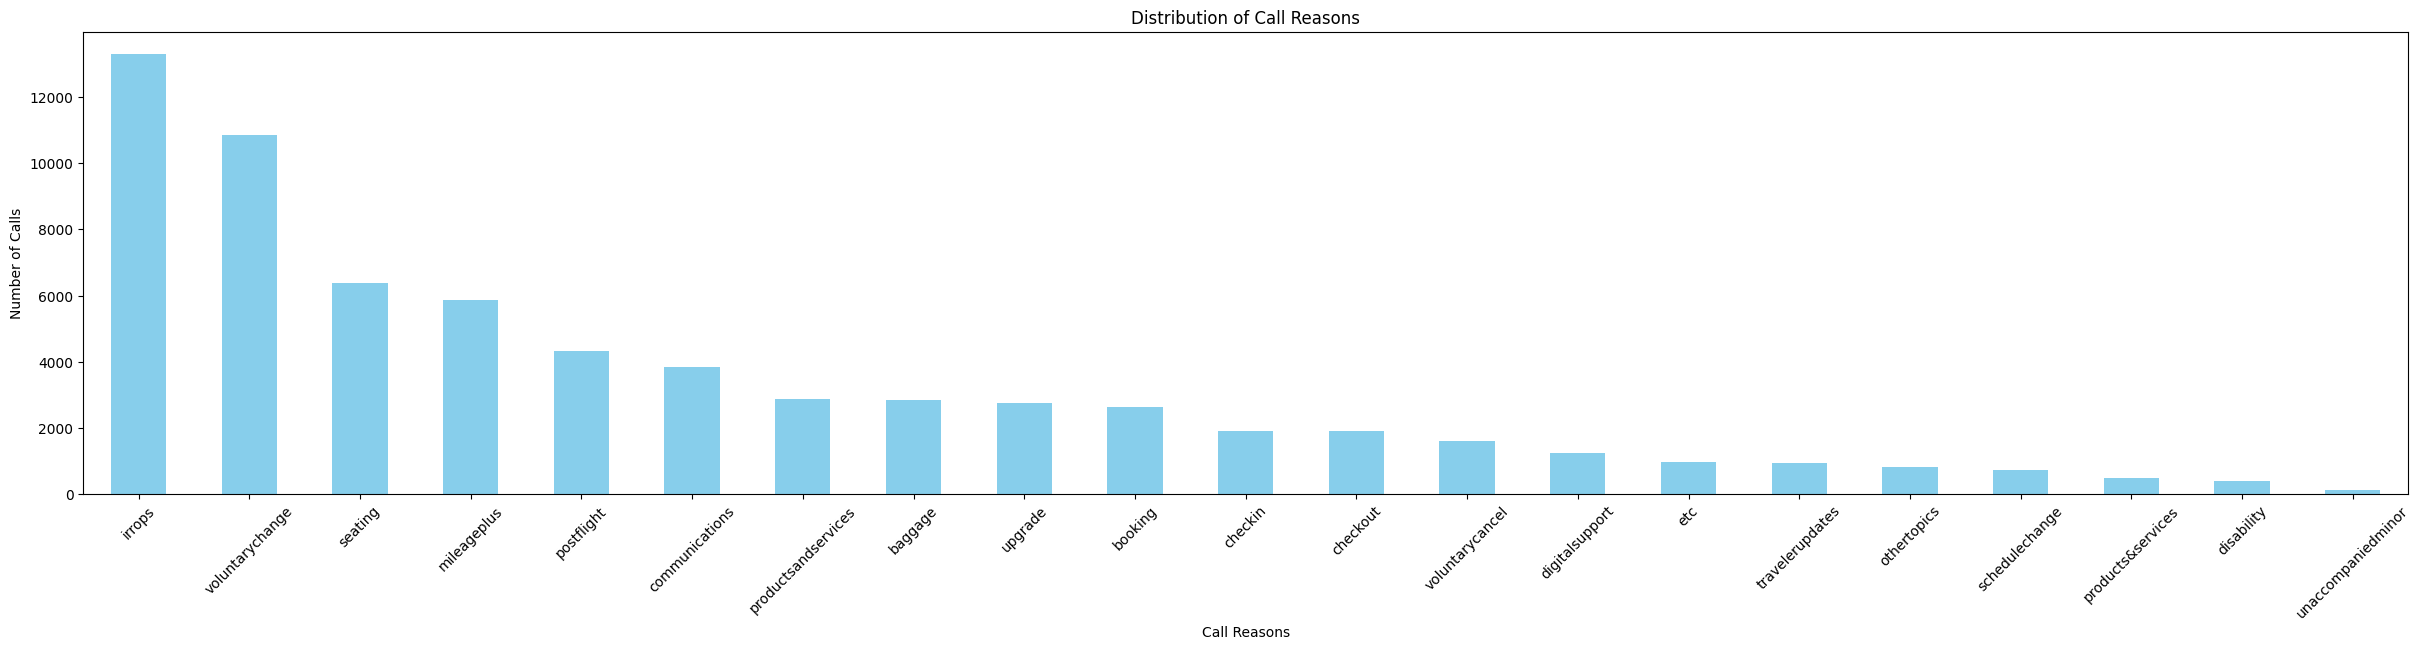

AHT by Call Reason:
    primary_call_reason  avg_handle_time
0               baggage       875.741525
1               booking       667.963595
2               checkin       929.968487
3              checkout      1741.557203
4        communications      1066.687500
5        digitalsupport       878.008163
6            disability       795.632754
7                   etc      1507.184874
8                irrops      1145.197205
9           mileageplus      1356.588617
10          othertopics       588.850856
11           postflight      1502.327945
12    products&services      1017.983193
13  productsandservices      1054.180672
14       schedulechange       730.834473
15              seating      1045.819324
16      travelerupdates      1083.265742
17   unaccompaniedminor      1207.500000
18              upgrade       930.832725
19      voluntarycancel      1261.381456
20      voluntarychange      1179.640487


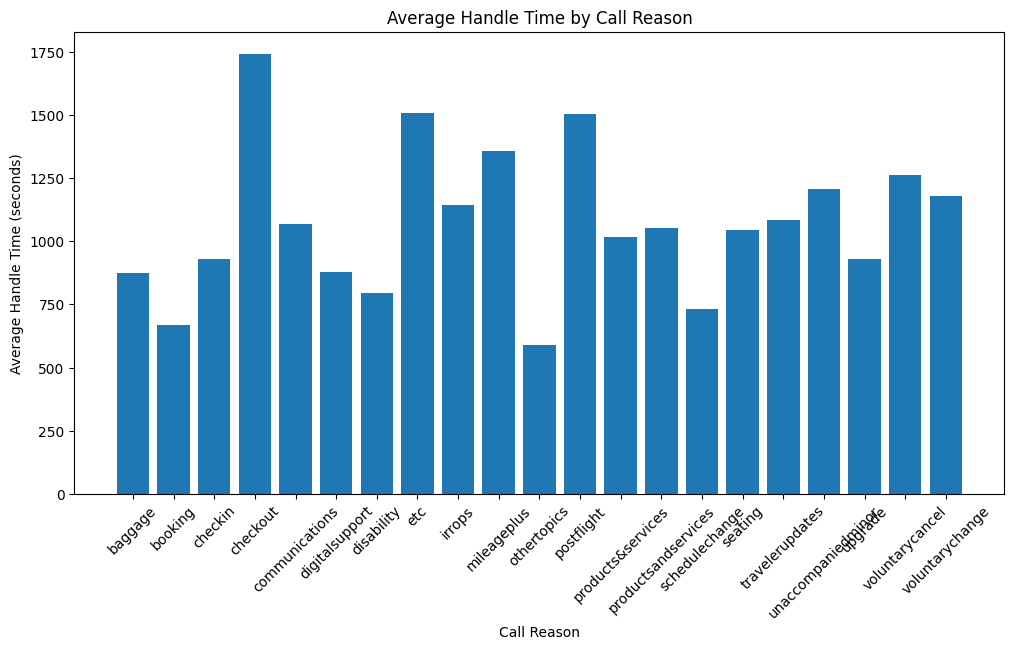

AHT by Agent:
     agent_id_x  avg_handle_time
0        102574      4080.000000
1        103651      1163.745583
2        106000      1164.356436
3        107876      1460.000000
4        112609      1447.500000
..          ...              ...
378      981776      1132.928571
379      981779      1137.746479
380      982131      1173.571429
381      992521      1437.209302
382      993862      1116.739130

[383 rows x 2 columns]


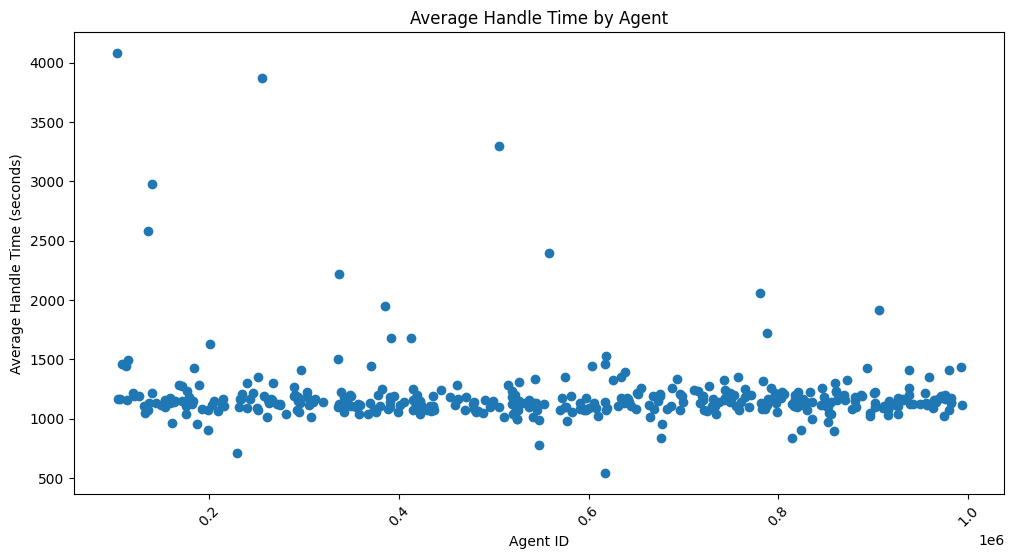

In [15]:
#AHT Analysis by Agent, Call Reason, and Sentiment
# Explore call reason distribution
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.strip()  # Remove extra spaces
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace(' ', '_').str.lower() # Replace space with underscore
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('_', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('__', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('___', '')
merged_data['primary_call_reason'] = merged_data['primary_call_reason'].str.replace('-', '')

call_reason_counts = merged_data['primary_call_reason'].value_counts()
print("Call Reason Distribution:")
print(call_reason_counts)

# Visualizing call reasons
plt.figure(figsize=(30, 6))
call_reason_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Call Reasons')
plt.xlabel('Call Reasons')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.show()

# AHT by call reason
aht_by_call_reason = merged_data.groupby('primary_call_reason')['call_duration'].mean().reset_index()
aht_by_call_reason.columns = ['primary_call_reason', 'avg_handle_time']
print("AHT by Call Reason:")
print(aht_by_call_reason)

# Plotting AHT by Call Reason using a bar chart for better visualization
plt.figure(figsize=(12, 6))
plt.bar(aht_by_call_reason['primary_call_reason'], aht_by_call_reason['avg_handle_time'])
plt.xlabel('Call Reason')
plt.ylabel('Average Handle Time (seconds)')
plt.title('Average Handle Time by Call Reason')
plt.xticks(rotation=45)
plt.show()

# AHT by agent
aht_by_agent = merged_data.groupby('agent_id_x')['call_duration'].mean().reset_index()
aht_by_agent.columns = ['agent_id_x', 'avg_handle_time']
print("AHT by Agent:")
print(aht_by_agent)

# Plotting AHT by Agent using a scatter plot for better visualization
plt.figure(figsize=(12, 6))
plt.scatter(aht_by_agent['agent_id_x'], aht_by_agent['avg_handle_time'])
plt.xlabel('Agent ID')
plt.ylabel('Average Handle Time (seconds)')
plt.title('Average Handle Time by Agent')
plt.xticks(rotation=45)
plt.show()


AST by Call Reason:
    primary_call_reason  avg_speed_to_answer
0               baggage           542.097458
1               booking           240.227531
2               checkin           355.840336
3              checkout           724.703390
4        communications           239.968750
5        digitalsupport           505.714286
6            disability           503.523573
7                   etc           544.285714
8                irrops           360.081136
9           mileageplus           361.015211
10          othertopics           238.753056
11           postflight           569.431871
12    products&services           297.857143
13  productsandservices           303.214286
14       schedulechange           240.820793
15              seating           570.824823
16      travelerupdates           690.032017
17   unaccompaniedminor           688.269231
18              upgrade           298.487947
19      voluntarycancel           539.514624
20      voluntarychange           5

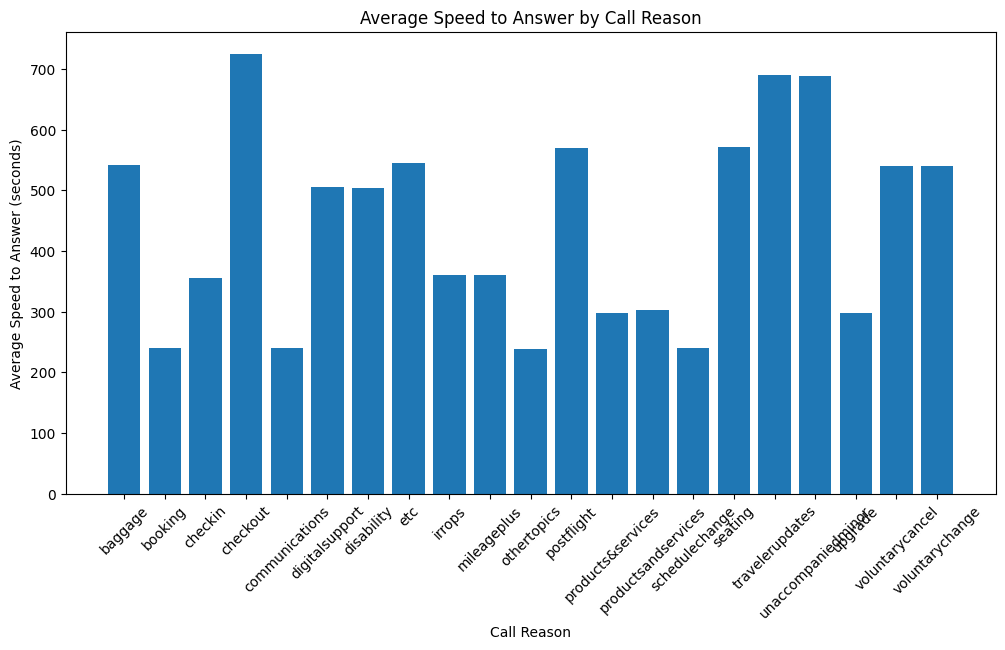

AST by Agent:
     agent_id_x  avg_speed_to_answer
0        102574           480.000000
1        103651           419.575972
2        106000           441.980198
3        107876           470.000000
4        112609           435.000000
..          ...                  ...
378      981776           427.071429
379      981779           439.718310
380      982131           439.285714
381      992521           453.488372
382      993862           440.652174

[383 rows x 2 columns]


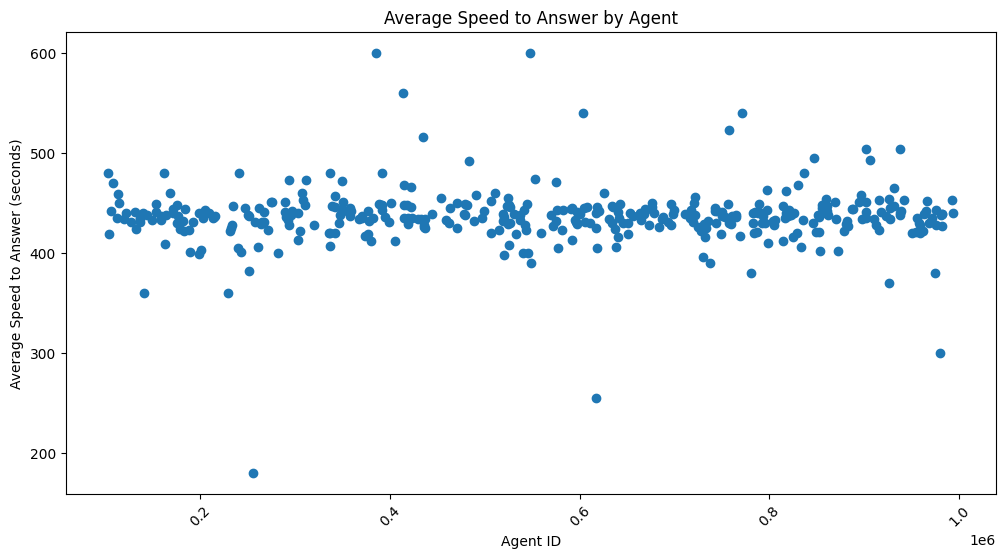

AST by Sentiment:
     average_sentiment  avg_speed_to_answer
0                -1.38                480.0
1                -1.25                540.0
2                -1.22                240.0
3                -1.19                600.0
4                -1.17                240.0
..                 ...                  ...
175               0.93                600.0
176               0.96                480.0
177               1.00                408.0
178               1.38                300.0
179               2.67                420.0

[180 rows x 2 columns]


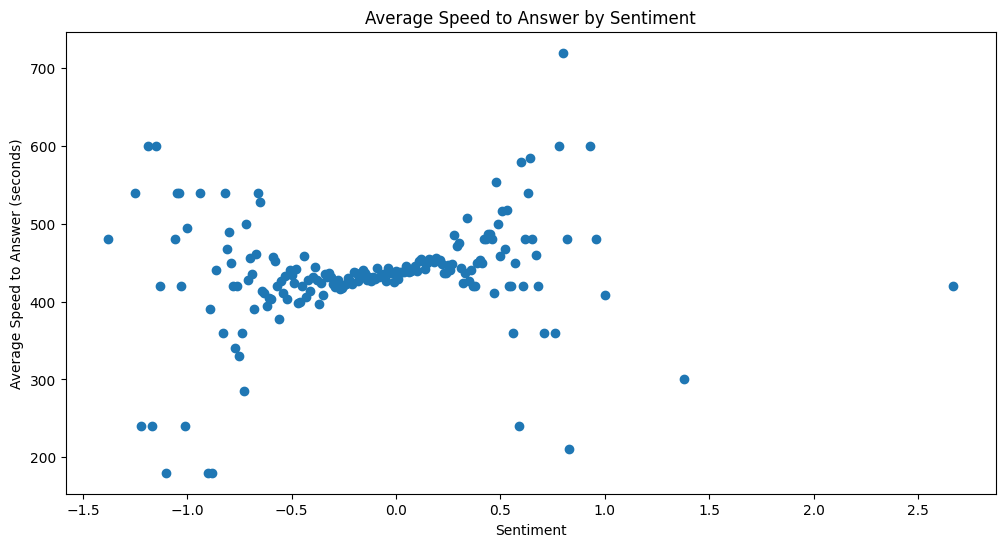

In [16]:
#AST Analysis by Agent, Call Reason, and Sentiment

# AST by call reason
ast_by_call_reason = merged_data.groupby('primary_call_reason')['wait_time'].mean().reset_index()
ast_by_call_reason.columns = ['primary_call_reason', 'avg_speed_to_answer']
print("AST by Call Reason:")
print(ast_by_call_reason)

# Plotting AST by Call Reason using a bar chart for better visualization
plt.figure(figsize=(12, 6))
plt.bar(ast_by_call_reason['primary_call_reason'], ast_by_call_reason['avg_speed_to_answer'])
plt.xlabel('Call Reason')
plt.ylabel('Average Speed to Answer (seconds)')
plt.title('Average Speed to Answer by Call Reason')
plt.xticks(rotation=45)
plt.show()

# AST by agent
ast_by_agent = merged_data.groupby('agent_id_x')['wait_time'].mean().reset_index()
ast_by_agent.columns = ['agent_id_x', 'avg_speed_to_answer']
print("AST by Agent:")
print(ast_by_agent)

# Plotting AST by Agent using a scatter plot for better visualization
plt.figure(figsize=(12, 6))
plt.scatter(ast_by_agent['agent_id_x'], ast_by_agent['avg_speed_to_answer'])
plt.xlabel('Agent ID')
plt.ylabel('Average Speed to Answer (seconds)')
plt.title('Average Speed to Answer by Agent')
plt.xticks(rotation=45)
plt.show()

# AST by sentiment
ast_by_sentiment = merged_data.groupby('average_sentiment')['wait_time'].mean().reset_index()
ast_by_sentiment.columns = ['average_sentiment', 'avg_speed_to_answer']
print("AST by Sentiment:")
print(ast_by_sentiment)

# Plotting AST by Sentiment using a scatter plot for better visualization
plt.figure(figsize=(12, 6))
plt.scatter(ast_by_sentiment['average_sentiment'], ast_by_sentiment['avg_speed_to_answer'])
plt.xlabel('Sentiment')
plt.ylabel('Average Speed to Answer (seconds)')
plt.title('Average Speed to Answer by Sentiment')
plt.show()


## Percentage Difference

In [17]:
# Calculate AST by call reason
ast_by_reason = merged_data.groupby('primary_call_reason')['wait_time'].mean().reset_index()
ast_by_reason.columns = ['primary_call_reason', 'avg_speed_to_answer']

# Find the highest and lowest AST
highest_ast = ast_by_reason['avg_speed_to_answer'].max()
lowest_ast = ast_by_reason['avg_speed_to_answer'].min()

# Calculate the percentage difference
percentage_difference = ((highest_ast - lowest_ast) / lowest_ast) * 100

print(f"Percentage difference between highest and lowest AST by call reason: {percentage_difference:.2f}%")


Percentage difference between highest and lowest AST by call reason: 203.54%


In [19]:
# Calculate AHT by call reason first:
aht_by_reason = merged_data.groupby('primary_call_reason')['call_duration'].mean().reset_index()
aht_by_reason.columns = ['primary_call_reason', 'avg_handle_time']

# Percentage difference between highest and lowest AHT by call reason
max_aht_reason = aht_by_reason['avg_handle_time'].max()
min_aht_reason = aht_by_reason['avg_handle_time'].min()
percent_diff = ((max_aht_reason - min_aht_reason) / min_aht_reason) * 100
print(f"Percentage difference between highest and lowest AHT call reasons: {percent_diff:.2f}%")


Percentage difference between highest and lowest AHT call reasons: 195.76%


In [20]:
# Predictive Modeling for Call Duration (AHT)

# Creating features for the model
merged_data['call_reason_encoded'] = merged_data['primary_call_reason'].astype('category').cat.codes

# Selecting features for classification
X = merged_data[['agent_id_x', 'call_duration', 'wait_time', 'average_sentiment']]  # Features
y = merged_data['call_reason_encoded']  # Target: Encoded Call Reason

# Checking for classes with only one sample
from collections import Counter
class_counts = Counter(y)
classes_to_remove = [cls for cls, count in class_counts.items() if count < 2]

# Filtering out rows corresponding to classes with only one sample
merged_data_filtered = merged_data[~merged_data['call_reason_encoded'].isin(classes_to_remove)]

# Updating X and y after filtering
X = merged_data_filtered[['agent_id_x', 'call_duration', 'wait_time', 'average_sentiment']]
y = merged_data_filtered['call_reason_encoded']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
# Predictive Modeling for Call Reasons

# Training a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [22]:
# Evaluating the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.2f}, R2: {train_r2:.2f}")
print(f"Test MSE: {test_mse:.2f}, R2: {test_r2:.2f}")

Train MSE: 0.33, R2: 0.96
Test MSE: 9.87, R2: -0.47


In [23]:
# Feature Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

Feature Importance:
             Feature  Importance
0         agent_id_x    0.447124
3  average_sentiment    0.219097
2          wait_time    0.173372
1      call_duration    0.160407


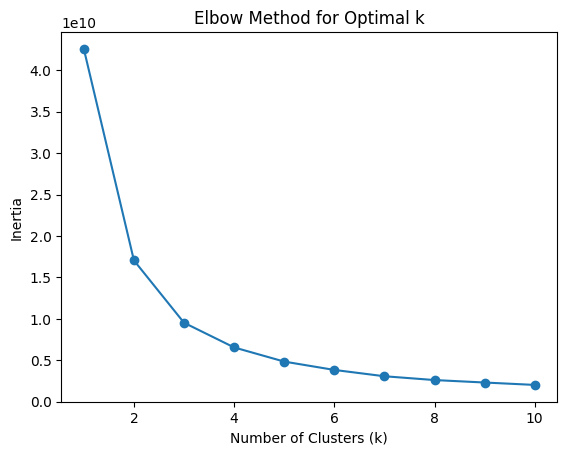

In [24]:
X_cluster = merged_data[['call_duration', 'wait_time']]

# Elbow Method to determine the optimal number of clusters
inertia = []
for i in range(1, 11):  # Try 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

## Based on the diagram, we have decided to have no. of clusters = 3

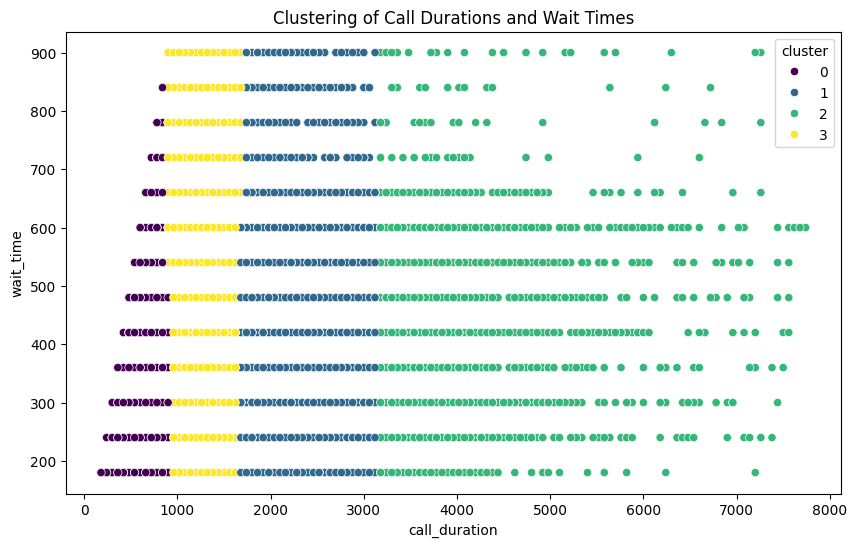

In [26]:
# Clustering Analysis for Pattern Recognition
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

X_clustering = merged_data[['call_duration', 'wait_time']]

# Creating an imputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or other strategies

# Fitting the imputer on your data and transform it
X_clustering_imputed = imputer.fit_transform(X_clustering)

# Now using the imputed data for clustering
kmeans = KMeans(n_clusters=4, random_state=42)
merged_data['cluster'] = kmeans.fit_predict(X_clustering_imputed)

# Visualizing the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='call_duration', y='wait_time', hue='cluster', palette='viridis')
plt.title('Clustering of Call Durations and Wait Times')
plt.show()

In [27]:
# Identifying primary reasons in each cluster
for i in range(3):
    print(f"Cluster {i}:")
    print(merged_data[merged_data['cluster'] == i]['primary_call_reason'].value_counts().head(10))

Cluster 0:
primary_call_reason
irrops                 7016
voluntarychange        4251
seating                2945
mileageplus            2487
communications         2280
booking                2186
baggage                1868
upgrade                1785
productsandservices    1641
checkin                1392
Name: count, dtype: int64
Cluster 1:
primary_call_reason
irrops                 1939
voluntarychange        1427
mileageplus            1171
postflight              932
checkout                566
communications          481
seating                 464
productsandservices     357
upgrade                 248
voluntarycancel         244
Name: count, dtype: int64
Cluster 2:
primary_call_reason
irrops                 430
mileageplus            356
postflight             295
voluntarychange        222
checkout               142
communications         133
voluntarycancel         72
checkin                 69
productsandservices     68
seating                 66
Name: count, dtype: int64

In [28]:
# Identifying the clusters that have the highest frequency of low-complexity issues (self-solvable)
cluster_summary = merged_data.groupby('cluster').agg({'call_duration': 'mean', 'primary_call_reason': 'count'}).reset_index()
cluster_summary.columns = ['cluster', 'avg_call_duration', 'call_count']
print("Cluster Summary for IVR Opportunities:")
print(cluster_summary)

# Automatically suggest IVR flows for the cluster with the shortest call duration and low-complexity issues
ivr_suggestion_cluster = cluster_summary[cluster_summary['avg_call_duration'] < aht].sort_values(by='call_count', ascending=False).iloc[0]
ivr_issues = merged_data[merged_data['cluster'] == ivr_suggestion_cluster['cluster']]['primary_call_reason'].unique()
print("Suggested Call Reasons for IVR Automation:")
print(ivr_issues)

Cluster Summary for IVR Opportunities:
   cluster  avg_call_duration  call_count
0        0         643.068161       33186
1        1        2166.370697        8627
2        2        4156.697697        2041
3        3        1187.791570       22799
Suggested Call Reasons for IVR Automation:
['booking' 'upgrade' 'irrops' 'postflight' 'seating' 'checkout'
 'othertopics' 'checkin' 'communications' 'schedulechange'
 'products&services' 'voluntarycancel' 'voluntarychange' 'mileageplus'
 'disability' 'baggage' 'digitalsupport' 'travelerupdates'
 'unaccompaniedminor' 'etc' 'productsandservices']


In [29]:
# Recommendations Based on Predictive Modeling and IVR Automation
def generate_advanced_recommendations(aht, ast, test_r2, ivr_issues):
    recommendations = []

    # Predictive Model-Based Recommendation for AHT Reduction
    if test_r2 > 0.5:  # If the model is sufficiently accurate
        recommendations.append("Use predictive modeling to predict and reduce long AHT by identifying contributing factors.")

    # AST Improvement Suggestions
    if ast > 30:
        recommendations.append("Optimize staffing levels during peak times to reduce AST and prevent agent overload.")

    # IVR Improvement Based on Clustering
    if len(ivr_issues) > 0:
        recommendations.append(f"Enhance IVR to automate issues like {', '.join(ivr_issues[:3])}, which frequently have short durations.")

    return recommendations


In [30]:
# Printing advanced recommendations
advanced_recommendations = generate_advanced_recommendations(aht, ast,test_r2, ivr_issues)
print("Advanced Recommendations:")
for rec in advanced_recommendations:
    print(f"- {rec}")


Advanced Recommendations:
- Optimize staffing levels during peak times to reduce AST and prevent agent overload.
- Enhance IVR to automate issues like booking, upgrade, irrops, which frequently have short durations.


In [31]:
merged_data.drop('agent_id_y',axis=1)

,call_id,customer_id,agent_id_x,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average,call_duration,wait_time,call_reason_encoded,cluster
0,4667960400,2033123310,963118,2024-07-31 23:56:00,2024-08-01 00:03:00,2024-08-01 00:34:00,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,voluntarycancel,neutral,angry,-0.04,0.39,2280.0,420.0,19,1
1,1122072124,8186702651,519057,2024-08-01 00:03:00,2024-08-01 00:06:00,2024-08-01 00:18:00,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,Standard,booking,calm,neutral,0.02,0.35,900.0,180.0,1,0
2,6834291559,2416856629,158319,2024-07-31 23:59:00,2024-08-01 00:07:00,2024-08-01 00:26:00,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,Standard,irrops,neutral,polite,-0.13,0.32,1620.0,480.0,8,3
3,2266439882,1154544516,488324,2024-08-01 00:05:00,2024-08-01 00:10:00,2024-08-01 00:17:00,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,upgrade,neutral,frustrated,-0.20,0.20,720.0,300.0,18,0
4,1211603231,5214456437,721730,2024-08-01 00:04:00,2024-08-01 00:14:00,2024-08-01 00:23:00,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,seating,neutral,polite,-0.05,0.35,1140.0,600.0,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66648,7569738090,7367304988,783441,2024-08-31 23:51:00,2024-08-31 23:57:00,2024-09-01 00:07:00,\n\nAgent: Thank you for calling United Airlin...,Kevin Warner,2.0,mileageplus,neutral,frustrated,-0.19,0.51,960.0,360.0,9,3
66649,1563273072,8022667294,413148,2024-08-31 23:48:00,2024-08-31 23:57:00,2024-09-01 00:25:00,\n\nAgent: Thank you for calling United Airlin...,Dennis Singleton DDS,Standard,postflight,calm,calm,0.05,0.34,2220.0,540.0,11,1
66650,8865997781,4474867021,980156,2024-08-31 23:55:00,2024-08-31 23:58:00,2024-09-01 00:06:00,\n\nAgent: Thank you for calling United Airlin...,Paul Mitchell,1.0,upgrade,calm,frustrated,0.03,0.22,660.0,180.0,18,0
66651,8019240181,9762042472,616988,2024-08-31 23:52:00,2024-08-31 23:58:00,2024-09-01 00:04:00,\n\nAgent: Thank you for calling United Airlin...,Kaylee Lang,Elite,upgrade,calm,polite,0.05,0.42,720.0,360.0,18,0


In [33]:
# Predictive Modeling for AHT
# Preparing data for AHT prediction
from sklearn.ensemble import RandomForestRegressor

X_aht = merged_data[['agent_id_x', 'call_reason_encoded', 'wait_time', 'average_sentiment']]  # Features
y_aht = merged_data['call_duration']  # Target: Call duration

# Split data into training and test sets for AHT prediction
X_aht_train, X_aht_test, y_aht_train, y_aht_test = train_test_split(X_aht, y_aht, test_size=0.2, random_state=42)

# Train a Random Forest Regressor to predict call duration (AHT)
rf_aht_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_aht_model.fit(X_aht_train, y_aht_train)

RandomForestRegressor(random_state=42)

In [34]:
# Making predictions for AHT
y_aht_pred_train = rf_aht_model.predict(X_aht_train)
y_aht_pred_test = rf_aht_model.predict(X_aht_test)

# Evaluating the AHT model
train_aht_mse = mean_squared_error(y_aht_train, y_aht_pred_train)
test_aht_mse = mean_squared_error(y_aht_test, y_aht_pred_test)
train_aht_r2 = r2_score(y_aht_train, y_aht_pred_train)
test_aht_r2 = r2_score(y_aht_test, y_aht_pred_test)

print(f"AHT Train MSE: {train_aht_mse:.2f}, R2: {train_aht_r2:.2f}")
print(f"AHT Test MSE: {test_aht_mse:.2f}, R2: {test_aht_r2:.2f}")

AHT Train MSE: 111327.55, R2: 0.82
AHT Test MSE: 648284.46, R2: -0.07


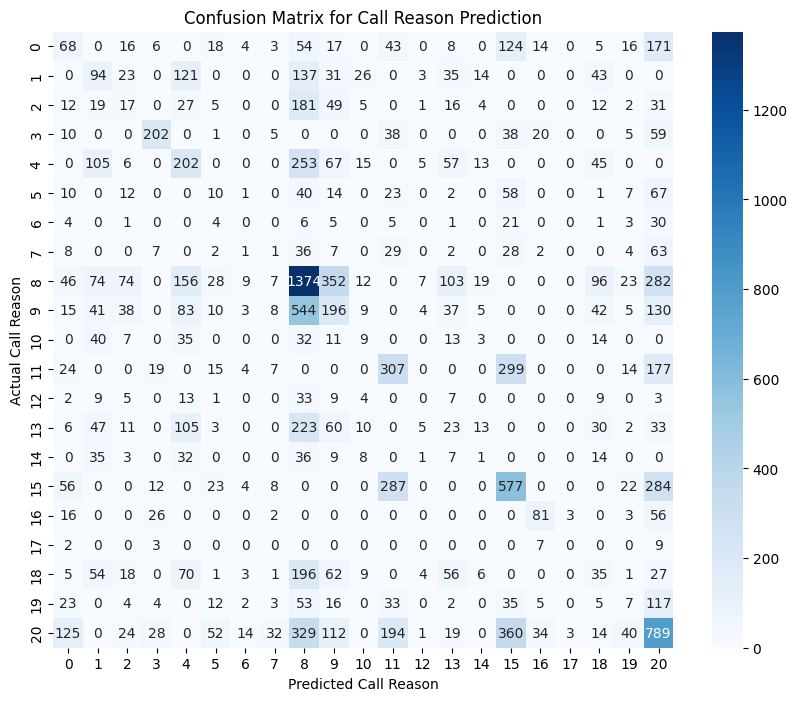

In [41]:
from sklearn.metrics import confusion_matrix

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Call Reason')
plt.ylabel('Actual Call Reason')
plt.title('Confusion Matrix for Call Reason Prediction')
plt.show()

In [40]:
# Making predictions on the test data using the trained Random Forest model
y_pred_test = rf_model.predict(X_test)

results_df = pd.DataFrame({'call_id': X_test.index, 'predicted_call_reason': y_pred_test})

esults_df = pd.merge(results_df, merged_data[['primary_call_reason']], left_on='call_id', right_index=True, how='left')

# Saving the results to a CSV file
results_df.to_csv('/content/drive/MyDrive/assignments/Skyhack/call_reason_predictions.csv', index=False)

print("Predictions saved to 'call_reason_predictions.csv'")


Predictions saved to 'call_reason_predictions.csv'
